In [ ]:
!pip install torchaudio==0.7.0

     |████████████████████████████████| 7.6MB 7.9MB/s 


In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
import torchvision
import numpy as np
from torchsummary import torchsummary
from IPython.display import Audio
import matplotlib.pyplot as plt
import random
import os
from glob import glob
from google.colab import drive
import pickle

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Get Librispeech dataset, and some noise 

In [ ]:
train_dataset = ta.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
# train_dataset = ta.datasets.LIBRISPEECH("./", url="dev-clean", download=True)

In [ ]:
!curl -L -o noises.zip https://github.com/indrasweb/chvoice/raw/main/noises.zip
!unzip -q noises.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133  100   133    0     0    588      0 --:--:-- --:--:-- --:--:--   585
100 15.7M  100 15.7M    0     0  15.2M      0  0:00:01  0:00:01 --:--:-- 15.2M


## Signal Processing Utils

In [ ]:
class DSP:

    def __init__(self, n_fft=254, hop_len=None):
        """ signal processing utils using torchaudio
        """
        self.n_fft = n_fft
        self.hop_len = n_fft//2 if hop_len is None else hop_len
        self.stft = ta.transforms.Spectrogram(
            n_fft=n_fft,
            hop_length=self.hop_len,
            win_length=n_fft,
            power=None
        )
        self.amplitude_to_db = ta.transforms.AmplitudeToDB()
        self.db_to_amplitude = lambda x: T.pow(T.pow(10.0, 0.1 * x), 1.)

    def sig_to_db_phase(self, sig):
        """ get dB and phase spectrograms of signal
            example usage:
                >>> sig, sr = torchaudio.load('sound.wav')
                >>> db, phase = chvoice.sig_to_db_phase(sig)
        """
        # represent input signal in time-frequency domain
        stft = self.stft(sig)
        # magnitude = amount of power/volume for each phase = frequency
        mag, phase = ta.functional.magphase(stft)
        # put magnitudes on log scale
        db = self.amplitude_to_db(mag)

        return db, phase

    def db_phase_to_sig(self, db, phase):
        """ get wav signal from db and phase spectrograms.
            example usage:
                >>> sig, sr = torchaudio.load('sound.wav')
                >>> db, phase = chvoice.sig_to_db_phase(sig)
                    ... do stuff to db ...
                >>> recovered_sig = chvoice.spec_to_sig(db, phase)
        """
        # go from log scale back to linear
        mag = self.db_to_amplitude(db)
        # recover full fourier transform of signal
        real = mag * T.cos(phase)
        imaginary = mag * T.sin(phase)
        complex = T.stack((real, imaginary), dim=-1)
        # inverse fourier transform to get signal
        sig = complex.istft(
            n_fft=self.n_fft,
            hop_length=self.hop_len
        )

        return sig

## Pre-processing and augmentation

In [ ]:
class Noiser:

    def __init__(self, noise_dir, noise_lvl=0.4):
        """ add noise to signal, where noise is randomly 
            selected wav from noise_dir.
            noise_lvl = ratio of noise to signal (additive)
        """
        self.nsr = noise_lvl
        fns = glob(f'{noise_dir}/*/*.wav', recursive=True)
        rs = ta.transforms.Resample()
        self.noises = []
        for fn in fns:
            noise, sr = ta.load(fn)
            noise = ta.transforms.Resample(sr, 16000)(noise)
            self.noises.append(noise.squeeze(0))

    def add_noise(self, sig):
        """ sig is expected to be one-dimensional (N,)
            snr = maximum signal to noise ratio 
        """
        # stochastic amount of noise
        noise_lvl = np.random.random() * self.nsr

        # 10% of the time just add white noise
        if np.random.random() > 0.9:
            white_noise = T.normal(
                mean=0., 
                std=0.025, size=sig.shape
            )
            return sig + white_noise*self.nsr


        # otherwise add a noise from the archive
        noise = random.choice(self.noises)
        if len(noise) < len(sig):
            n_repeats = int(np.ceil(len(sig) / len(noise)))
            noise = T.repeat_interleave(noise, n_repeats)
        
        return sig + noise[:len(sig)]*self.nsr

In [ ]:
denormalize = torchvision.transforms.Compose([ 
    torchvision.transforms.Normalize(mean=0., std=1/18),
    torchvision.transforms.Normalize(mean=32., std=1.)
])

normalize = torchvision.transforms.Normalize(mean=-32., std=18)

def preprocess(X, dsp, noiser):
    clean = []
    noisy = []
    wavs = [d[0] for d in X]

    for wav in wavs:

        db, phase = dsp.sig_to_db_phase(wav)
        if db.size(2) < 128:
            continue

        # make clean chunks of audio
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        chunks = normalize(chunks)
        clean.append(chunks)

        # make corresponding noisy chunks of audio
        aug_wav = noiser.add_noise(wav.squeeze(0))
        db, phase = dsp.sig_to_db_phase(aug_wav.unsqueeze(0))
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        chunks = normalize(chunks)
        noisy.append(chunks)

    clean = T.vstack(clean).unsqueeze(1)
    noisy = T.vstack(noisy).unsqueeze(1)
    
    return clean, noisy

## Model Definition (UNet)

In [ ]:
### CREDIT : https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, 
                mode='bilinear', 
                align_corners=True
            )
            self.conv = DoubleConv(
                in_channels, 
                out_channels, 
                in_channels // 2
            )
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, 
                in_channels // 2, 
                kernel_size=2, 
                stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = T.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Train

In [ ]:
dsp = DSP(254)
noiser = Noiser("./noises/")

train_loader = T.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=15,
    shuffle=True,
    collate_fn=lambda x: preprocess(x, dsp, noiser),
)

model = UNet(1, 1).to(DEVICE)
optim = T.optim.Adam(model.parameters(), 4e-4)
crit = nn.MSELoss()
loss_history = []

In [ ]:
for epoch in range(1, 8):
    for i, (clean, noisy) in enumerate(train_loader):
        clean = clean[:64,:,:,:].to(DEVICE)
        noisy = noisy[:64,:,:,:].to(DEVICE)
        optim.zero_grad()
        pred = model(noisy)
        loss = crit(pred, clean)
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        if not i%10:
            print(f'E{epoch}:{i}\tLoss {loss.item():.4f}')

    pth = 'drive/MyDrive/speech-enhance-models/'
    with open(pth+'loss_history.pkl', 'wb') as f:
        pickle.dump(loss_history, f)

    T.save(model.state_dict(), pth+f'model-{epoch}.pkl')

E1:0	Loss 0.7801
E1:10	Loss 0.1581
E1:20	Loss 0.1622
E1:30	Loss 0.1063
E1:40	Loss 0.0602
E1:50	Loss 0.0665
E1:60	Loss 0.0766
E1:70	Loss 0.0567
E1:80	Loss 0.1092
E1:90	Loss 0.0765
E1:100	Loss 0.9089
E1:110	Loss 0.0511
E1:120	Loss 0.0532
E1:130	Loss 0.0867
E1:140	Loss 0.0344
E1:150	Loss 0.1425
E1:160	Loss 0.1050
E1:170	Loss 0.0579
E1:180	Loss 0.0640
E1:190	Loss 0.0342
E1:200	Loss 0.0858
E1:210	Loss 0.0530
E1:220	Loss 0.1786
E1:230	Loss 0.1044
E1:240	Loss 0.0339
E1:250	Loss 0.0562
E1:260	Loss 0.0786
E1:270	Loss 0.0881
E1:280	Loss 0.0762
E1:290	Loss 0.0745
E1:300	Loss 0.0389
E1:310	Loss 0.0542
E1:320	Loss 0.0394
E1:330	Loss 0.0366
E1:340	Loss 0.0791
E1:350	Loss 0.0514
E1:360	Loss 0.1261
E1:370	Loss 0.0456
E1:380	Loss 0.0585
E1:390	Loss 0.0492
E1:400	Loss 0.0591
E1:410	Loss 0.0420
E1:420	Loss 0.0710
E1:430	Loss 0.0285
E1:440	Loss 0.0389
E1:450	Loss 0.0606
E1:460	Loss 0.1095
E1:470	Loss 0.0591
E1:480	Loss 0.3515
E1:490	Loss 0.0818
E1:500	Loss 0.0615
E1:510	Loss 0.0741
E1:520	Loss 0.0646
E1:5

# Evaluate

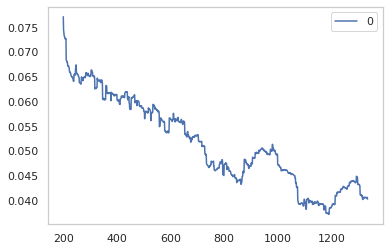

In [ ]:
import pandas as pd
import seaborn as sns
sns.set()
sns.color_palette("viridis", as_cmap=True)
sns.set_style("whitegrid", {'axes.grid' : False})

df = pd.DataFrame(loss_history).rolling(200).mean()
df.plot()

In [ ]:
test_dataset = ta.datasets.LIBRISPEECH("./", url="test-clean", download=True)

In [ ]:
dsp = DSP(254)
noiser = Noiser("./noises/")

test_loader = T.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=15,
    shuffle=True,
    collate_fn=lambda x: preprocess(x, dsp, noiser),
)

model = UNet(1, 1).to(DEVICE)
optim = T.optim.Adam(model.parameters(), 4e-4)
crit = nn.MSELoss()

In [ ]:
path = f'drive/MyDrive/speech-enhance-models/model-7.pkl'
model.load_state_dict(T.load(path))
model = model.to(DEVICE)

In [ ]:
def evaluate(noisy_sig, clean_sig, model, plot_spectrograms=True):
    
    db, phase = dsp.sig_to_db_phase(noisy_sig)
    assert db.size(2) >= 128, 'wav too small'
    db_clean, _ = dsp.sig_to_db_phase(clean_sig)

    if plot_spectrograms:
        print('input dB spectrogram (noisy)')
        fig, ax = plt.subplots(figsize=(12,4))
        ax.imshow(db[0])
        plt.show()

        print('target dB spectogram (clean)')
        fig, ax = plt.subplots(figsize=(12,4))
        ax.imshow(db_clean[0])
        plt.show()

    chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
    chunks = normalize(chunks).unsqueeze(1).to(DEVICE)
                 
    with T.no_grad():
        proc = denormalize(model(chunks))
    
    db_out = T.cat([c for c in proc.squeeze(1)], dim=1).cpu()
    
    if plot_spectrograms:
        print('db spectrogram (prediction)')
        fig, ax = plt.subplots(figsize=(12,4))
        ax.imshow(db_out.numpy())
        plt.show()
    
    phase_clipped = phase[0,:,:db_out.size(1)]
    sig = dsp.db_phase_to_sig(db_out, phase_clipped)

    diff = db_out.numpy() - db[0].numpy()[:, :db_out.size(1)]
    if plot_spectrograms:
        print('noisy - prediciton (difference)')
        fig, ax = plt.subplots(figsize=(12,4))
        ax.imshow(diff)
        plt.show()
    
    print("Root mean squared difference")
    print(np.sqrt(np.mean(diff*diff)))
    
    return sig

Load a sample, and add noise to it

In [ ]:
in_sig = test_dataset[80][0]
Audio(in_sig, rate=16000)

In [ ]:
wobbly = noiser.add_noise(in_sig.squeeze(0)).unsqueeze(0)
Audio(wobbly, rate=16000)

input dB spectrogram (noisy)


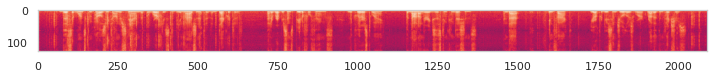

target dB spectogram (clean)


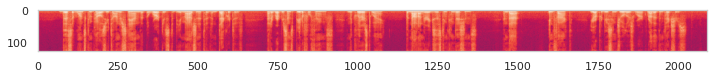

db spectrogram (prediction)


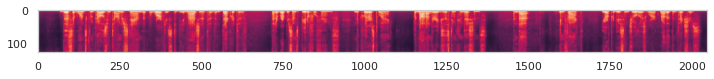

noisy - prediciton (difference)


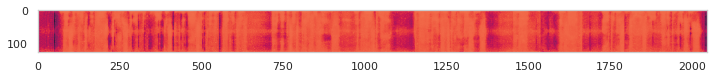

Root mean squared difference
4.5818367


In [ ]:
model = model.eval()
out_sig = evaluate(wobbly, in_sig, model)
model = model.train()  # set model back to train mode
Audio(out_sig, rate=16000)

In [ ]:
wobbly = noiser.add_noise(in_sig.squeeze(0)).unsqueeze(0)
Audio(wobbly, rate=16000)

input dB spectrogram (noisy)


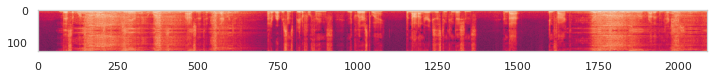

target dB spectogram (clean)


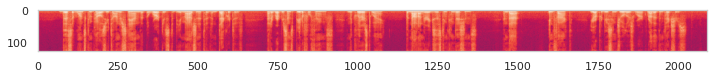

db spectrogram (prediction)


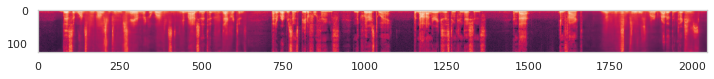

noisy - prediciton (difference)


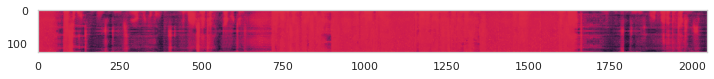

Root mean squared difference
6.7955856


In [ ]:
model = model.eval()
out_sig = evaluate(wobbly, in_sig, model)
model = model.train()  # set model back to train mode
Audio(out_sig, rate=16000)

In [ ]:
wobbly = noiser.add_noise(in_sig.squeeze(0)).unsqueeze(0)
Audio(wobbly, rate=16000)

input dB spectrogram (noisy)


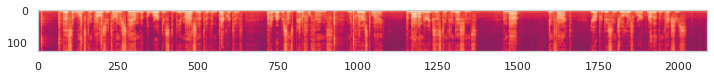

target dB spectogram (clean)


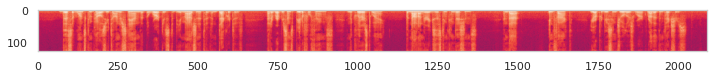

db spectrogram (prediction)


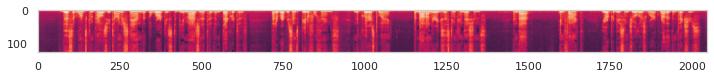

noisy - prediciton (difference)


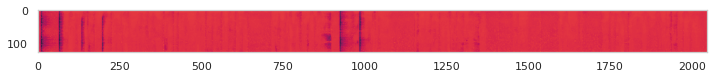

Root mean squared difference
2.322705


In [ ]:
model = model.eval()
out_sig = evaluate(wobbly, in_sig, model)
model = model.train()  # set model back to train mode
Audio(out_sig, rate=16000)

In [ ]:
wobbly = in_sig + T.normal(mean=0., std=0.025, size=in_sig.shape) * 0.3
Audio(wobbly, rate=16000)

input dB spectrogram (noisy)


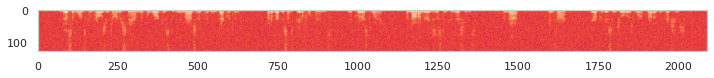

target dB spectogram (clean)


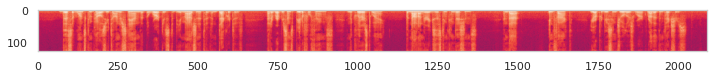

db spectrogram (prediction)


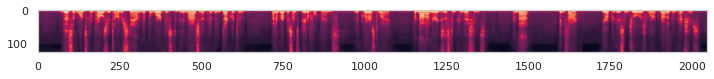

noisy - prediciton (difference)


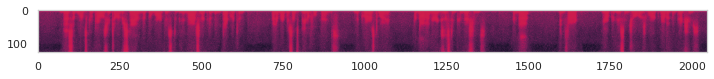

Root mean squared difference
10.904436


In [ ]:
model = model.eval()
out_sig = evaluate(wobbly, in_sig, model)
model = model.train()  # set model back to train mode
Audio(out_sig, rate=16000)

In [ ]:
class ReverbEcho:
    """
    CREDIT :: https://github.com/facebookresearch/denoiser/blob/e27bf5cdcda6e6ffc3a332763411d864210f94c8/denoiser/augment.py

    Hacky Reverb but runs on GPU without slowing down training.
    This reverb adds a succession of attenuated echos of the input
    signal to itself. Intuitively, the delay of the first echo will happen
    after roughly 2x the radius of the room and is controlled by `first_delay`.
    Then RevEcho keeps adding echos with the same delay and further attenuation
    until the amplitude ratio between the last and first echo is 1e-3.
    The attenuation factor and the number of echos to adds is controlled
    by RT60 (measured in seconds). RT60 is the average time to get to -60dB
    (remember volume is measured over the squared amplitude so this matches
    the 1e-3 ratio).
    At each call to RevEcho, `first_delay`, `initial` and `RT60` are
    sampled from their range. Then, to prevent this reverb from being too regular,
    the delay time is resampled uniformly within `first_delay +- 10%`,
    as controlled by the `jitter` parameter. Finally, for a denser reverb,
    multiple trains of echos are added with different jitter noises.
    Args:
        - initial: amplitude of the first echo as a fraction
            of the input signal. For each sample, actually sampled from
            `[0, initial]`. Larger values means louder reverb. Physically,
            this would depend on the absorption of the room walls.
        - rt60: range of values to sample the RT60 in seconds, i.e.
            after RT60 seconds, the echo amplitude is 1e-3 of the first echo.
            The default values follow the recommendations of
            https://arxiv.org/ftp/arxiv/papers/2001/2001.08662.pdf, Section 2.4.
            Physically this would also be related to the absorption of the
            room walls and there is likely a relation between `RT60` and
            `initial`, which we ignore here.
        - first_delay: range of values to sample the first echo delay in seconds.
            The default values are equivalent to sampling a room of 3 to 10 meters.
        - repeat: how many train of echos with differents jitters to add.
            Higher values means a denser reverb.
        - jitter: jitter used to make each repetition of the reverb echo train
            slightly different. For instance a jitter of 0.1 means
            the delay between two echos will be in the range `first_delay +- 10%`,
            with the jittering noise being resampled after each single echo.
        - keep_clean: fraction of the reverb of the clean speech to add back
            to the ground truT. 0 = dereverberation, 1 = no dereverberation.
        - sample_rate: sample rate of the input signals.
    """

    def __init__(self, initial=0.2, rt60=(0.1, 1.0), first_delay=(0.01, 0.03),
                 repeat=31, jitter=0.1, keep_clean=0.1, sample_rate=16000):
        super().__init__()
        self.initial = initial
        self.rt60 = rt60
        self.first_delay = first_delay
        self.repeat = repeat
        self.jitter = jitter
        self.keep_clean = keep_clean
        self.sample_rate = sample_rate

    def reverb(self, sig):
        """
        Return the reverb for a single sig.
        """

        initial = random.random() * self.initial
        first_delay = random.uniform(*self.first_delay)
        rt60 = random.uniform(*self.rt60)

        length = sig.shape[-1]
        reverb = T.zeros_like(sig)
        
        for _ in range(self.repeat):
            frac = 1  # what fraction of the first echo amplitude is still here
            echo = initial * sig
            while frac > 1e-3:
                # First jitter noise for the delay
                jitter = 1 + self.jitter * random.uniform(-1, 1)
                delay = min(
                    1 + int(jitter * first_delay * self.sample_rate),
                    length)
                # Delay the echo in time by padding with zero on the left
                echo = F.pad(echo[:, :, :-delay], (delay, 0))
                reverb += echo

                # Second jitter noise for the attenuation
                jitter = 1 + self.jitter * random.uniform(-1, 1)
                # we want, with `d` the attenuation, d**(rt60 / first_ms) = 1e-3
                # i.e. log10(d) = -3 * first_ms / rt60, so that
                attenuation = 10**(-3 * jitter * first_delay / rt60)
                echo *= attenuation
                frac *= attenuation

        return reverb

In [ ]:
reverber = ReverbEcho()
sig_reverb = reverber.reverb(in_sig.unsqueeze(0))
sig_reverb = sig_reverb.squeeze(0)
Audio(sig_reverb, rate=16000)

input dB spectrogram (noisy)


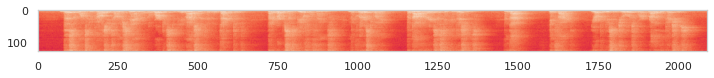

target dB spectogram (clean)


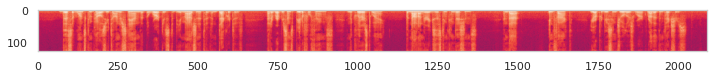

db spectrogram (prediction)


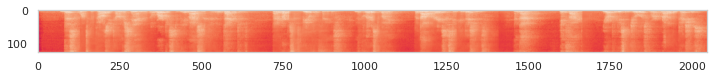

noisy - prediciton (difference)


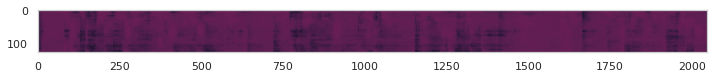

Root mean squared difference
3.2327123


In [ ]:
model = model.eval()
out_sig = evaluate(sig_reverb, in_sig, model)
model = model.train()  # set model back to train mode
Audio(out_sig, rate=16000)